In [ ]:
import numpy as np
import keras
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from time import time
%matplotlib inline

In [ ]:
# Set random state

np.random.seed(20)

In [ ]:
# Load the data
train_raw = loadmat('/content/sample_data/train_32x32.mat')
test_raw = loadmat('/content/sample_data/test_32x32.mat')

In [ ]:
# Load images and labels

train_images = np.array(train_raw['X'])
test_images = np.array(test_raw['X'])

train_labels = train_raw['y']
test_labels = test_raw['y']

In [ ]:
train_images = np.moveaxis(train_images, -1, 0)
test_images = np.moveaxis(test_images, -1, 0)

print(train_images.shape)
print(test_images.shape)

(73257, 32, 32, 3)
(26032, 32, 32, 3)


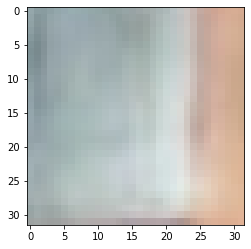

Label:  [4]


In [ ]:
# Plot a random image and its label

plt.imshow(train_images[13000])
plt.show()

print('Label: ', train_labels[13000])

In [ ]:
# Convert train and test images into 'float64' type

train_images = train_images.astype('float64')
test_images = test_images.astype('float64')

In [ ]:
# Convert train and test labels into 'int64' type

train_labels = train_labels.astype('int64')
test_labels = test_labels.astype('int64')

In [ ]:
# Normalize the images data

print('Min: {}, Max: {}'.format(train_images.min(), train_images.max()))

train_images /= 255.0
test_images /= 255.0

Min: 0.0, Max: 255.0


In [ ]:
# One-hot encoding of train and test labels

lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)
test_labels = lb.fit_transform(test_labels)

In [ ]:
# Split train data into train and validation sets

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels,
                                                  test_size=0.15, random_state=22)

In [ ]:
X_train = X_train[:40000,:,:,:]
y_train = y_train[:40000]

X_val = X_val[:10000,:,:,:]
y_val = y_val[:10000]

In [ ]:
y_val.shape

(10000, 10)

In [ ]:
# Data augmentation (CNN Layer)

datagen = ImageDataGenerator(rotation_range=8,
                             zoom_range=[0.95, 1.05],
                             height_shift_range=0.10,
                             shear_range=0.15)

In [ ]:
# Define actual model


keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Conv2D(32, (5, 5), padding='same', 
                           activation='relu',
                           input_shape=(32, 32, 3)),
                          
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(64, (5, 5), padding='same', 
                        activation='relu'),
     
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),    
    keras.layers.Dropout(0.3),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1000, activation='relu'),
    keras.layers.Dropout(0.4),    
    keras.layers.Dense(10,  activation='softmax')
])

early_stopping = keras.callbacks.EarlyStopping(patience=8)
optimizer = keras.optimizers.Adam(lr=1e-3, amsgrad=True)
model_checkpoint = keras.callbacks.ModelCheckpoint(
                   '/content/sample_data/best_cnn.h5', 
                   save_best_only=True)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 64)          0

In [ ]:
# Fit model in order to make predictions
start = time()
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),
                              epochs=30, validation_data=(X_val, y_val),
                              callbacks=[early_stopping, model_checkpoint])
end = time()
end = end - start
print('Time taken to train the data:{:.3f} seconds'.format(end))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
313/313 [==============================] - 213s 678ms/step - loss: 2.5569 - accuracy: 0.3864 - val_loss: 1.8754 - val_accuracy: 0.5288
Epoch 2/30
313/313 [==============================] - 209s 669ms/step - loss: 0.7473 - accuracy: 0.7624 - val_loss: 0.4463 - val_accuracy: 0.8721
Epoch 3/30
313/313 [==============================] - 204s 652ms/step - loss: 0.6026 - accuracy: 0.8115 - val_loss: 0.3859 - val_accuracy: 0.8910
Epoch 4/30
313/313 [==============================] - 203s 648ms/step - loss: 0.5215 - accuracy: 0.8360 - val_loss: 0.3625 - val_accuracy: 0.8947
Epoch 5/30
313/313 [==============================] - 203s 647ms/step - loss: 0.4715 - accuracy: 0.8549 - val_loss: 0.3653 - val_accuracy: 0.8914
Epoch 6/30
313/313 [==============================] - 202s 646ms/step - loss: 0.4308 - accuracy: 0.8663 - val_loss: 0.3595 - val_accuracy: 0.8994
Epoch 7/30
313/313 [==============================] - 201s 642ms/step - loss: 0.4052 - accuracy: 0.8756 - val_loss: 0.3234 -

In [ ]:
# Evaluate train and validation accuracies and losses

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

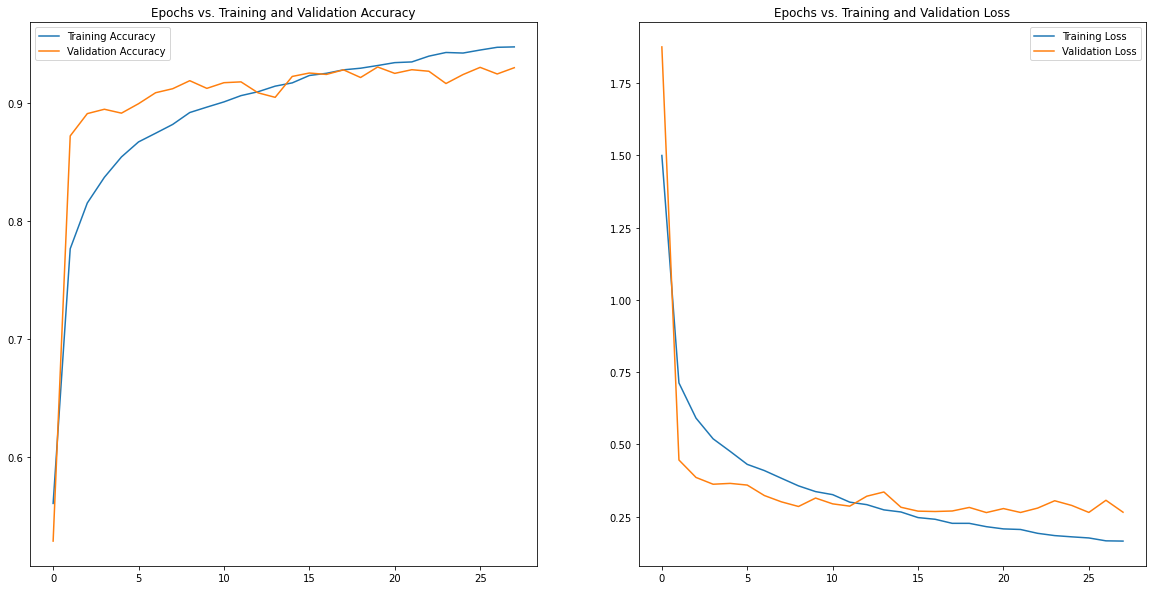

In [ ]:
# Visualize epochs vs. train and validation accuracies and losses

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Epochs vs. Training and Validation Accuracy')
    
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Epochs vs. Training and Validation Loss')

plt.show()

In [ ]:
# Evaluate model on test data
test_loss, test_acc = model.evaluate(x=test_images, y=test_labels, verbose=0)

print('Test accuracy is: {:0.4f} \nTest loss is: {:0.4f}'.
      format(test_acc, test_loss))

Test accuracy is: 0.9231 
Test loss is: 0.2953


In [ ]:
# Get predictions and apply inverse transformation to the labels (visualization and impacts)
y_pred = model.predict(X_train)

y_pred = lb.inverse_transform(y_pred, lb.classes_)
y_train = lb.inverse_transform(y_train, lb.classes_)


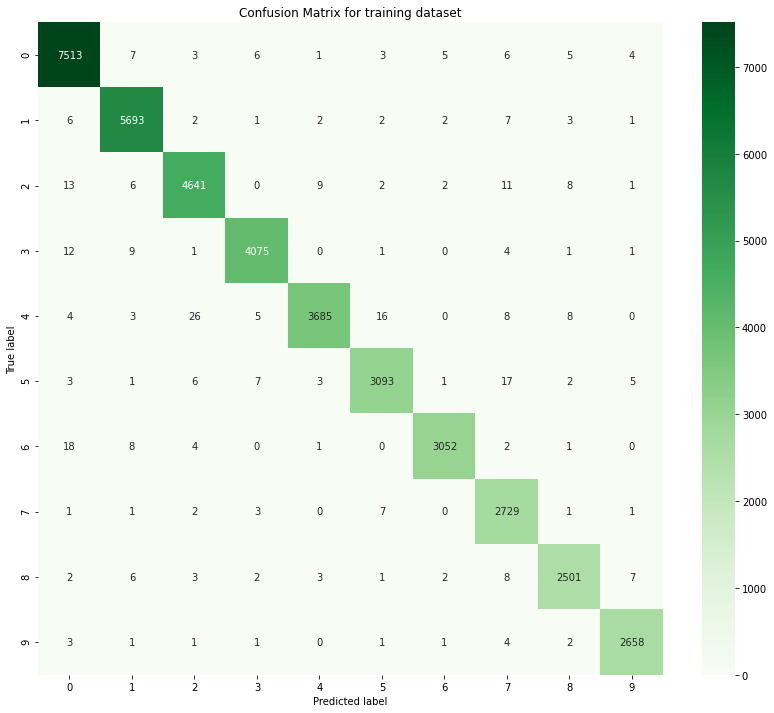

In [ ]:
# Plot the confusion matrix

matrix = confusion_matrix(y_train, y_pred, labels=lb.classes_)

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(matrix, annot=True, cmap='Greens', fmt='d', ax=ax)
plt.title('Confusion Matrix for training dataset')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
# Ignore the errors in the plots

np.seterr(all='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [ ]:
# Get convolutional layers

layers = [model.get_layer('conv2d_1')
         ]

In [ ]:
# Define a model which gives the outputs of the layers

layer_outputs = [layer.output for layer in layers]
activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
# Create a list with the names of the layers

layer_names = []
for layer in layers:
    layer_names.append(layer.name)

In [ ]:
# Define a function which will plot the convolutional filters

def plot_convolutional_filters(img):
    
    img = np.expand_dims(img, axis=0)
    activations = activation_model.predict(img)
    images_per_row = 9
    
    for layer_name, layer_activation in zip(layer_names, activations): 
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols): 
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='plasma')

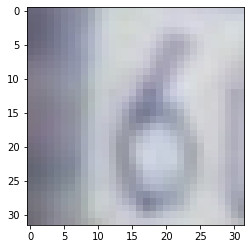

In [ ]:
img = X_train[13529]
plt.imshow(img)
plt.show()

In [ ]:
plot_convolutional_filters(img)

IndexError: ignored